In [2]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# 1. Data Preparation 1: Preparing Target Variable

In our classification task, we will be predicting a binary variable that indicates whether or not a highschool's average SAT score is considered "outperforming." This indicator variable is derived based on a threshold applied to the numeric average score. If a school's average SAT score is above 1080, for the purposes of this analysis, it is considered outperforming. WHile these classes aren't perfectly even, that is expected, we wouldn't expect to see an equal amount of outperforming and non-outperforming schools. The 262-159 class split isn't large enough for us to worry too much about class inbalance.

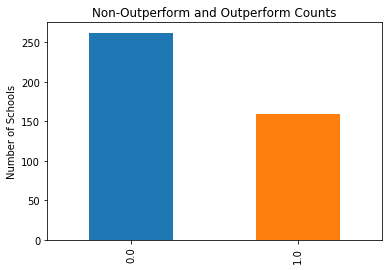

0.0    262
1.0    159
Name: sat_high_level, dtype: int64

In [8]:
import numpy as np
import pandas as pd
#hs_2017 = pd.read_csv("https://github.com/jeffweltman/MSDS7331/raw/master/hs_2017.csv",index_col=0)
hs_2017 = pd.read_csv("hs_2017.csv")
y = hs_2017.sat_high_level.values
hs_2017.sat_high_level.value_counts().plot(kind='bar')
plt.title("Non-Outperform and Outperform Counts")
plt.ylabel("Number of Schools")
plt.show()
hs_2017.sat_high_level.value_counts()

In our regression task, we will be predicting the 5-year graduation rate....** more explanation **

# 2. Data Preparation 2: Final Dataset

Our two tasks require slightly different treatment

In [11]:
x = hs_2017.drop(columns=['nc_district', 'sat_high_level', "sat_avg_score_num"])

# 3. Modeling and Evaluation: Evaluation Metrics

# 4. Modeling and Evaluation: Data Sampling Methodology

# 5/6. Modeling and Analysis
## 5/6A. Classification Task

### Logistic Regression

### K Nearest Neighbors

### Random Forest

The Random Forest is a relatively new machine learning algorithm, invented in the 1990s. It is an ensemble method extension of the decision tree. As an extension of decision trees, random forests can be used for both classification and regression. We will be focusing exclusively on classification random forest's, but most commentary can be applied to both types of random forests. 

In the random forest algorithm, you take a random subset of your data's features, grow a shallow decision tree, take note of the predicted class, then repeat that process over and over. The class that is predicted most often by all of the decision trees is the output of the random forest. Given the above description, there are **three primary parameters** available to optimize the algorithm. 

- **n_features:** This parameter indicates the number of random features to select from the full dataset for each tree in the forest. This can either be a specific number, or a selection method.
- **max_depth:** This parameter drives the maximum depth of any of the decision trees grown
- **n_estimators:** The number of trees to grow

Below is a visual explanation for how the 3 parameters affect a random forest , with the names of the parameters highlighted in red.

<center><img src='random_forest.png' width = '75%'></center>

There are actually several other parameters available when growing a random forest, they are mostly related to the details of how each individual decision tree is grown. These parameters include the metric used for node splitting (gini impurity or entropy), the minimum number of samples required to split a node, the minimum impurity decrease to split a node, and others.

Below we will grow a random forest using the default parameters, and examine the resulting model's quality based on previous discussed metrics.

Precision: 0.88
Accuracy: 0.82
Recall: 0.61
F1 Score: 0.72


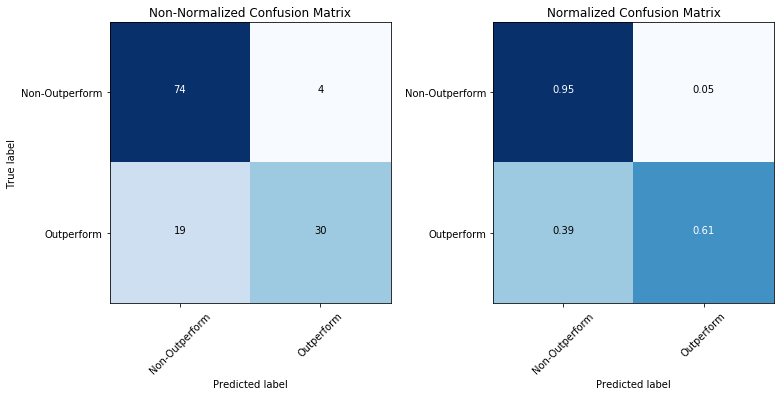

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, recall_score, f1_score

import numpy as np
import pandas as pd

# Generate a 60/40 training/test split of data
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
# Generate & train instance of RandomForest classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
# Print classification metrics & confusion matrix (normalized & non)
print("Precision: %0.2f" % precision_score(y_test, rf.predict(X_test)))
print("Accuracy: %0.2f" % accuracy_score(y_test, rf.predict(X_test)))
print("Recall: %0.2f" % recall_score(y_test, rf.predict(X_test)))

rf_precision = precision_score(y_test, rf.predict(X_test))
rf_recall = recall_score(y_test, rf.predict(X_test))
rf_accuracy = accuracy_score(y_test, rf.predict(X_test))

# Calc and plot confusion matrices
cm = confusion_matrix(y_test, rf.predict(X_test))
plt.figure(figsize = (11, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, ['Non-Outperform', 'Outperform'])
plt.title("Non-Normalized Confusion Matrix")
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, ['Non-Outperform', 'Outperform'], normalize=True)
plt.title("Normalized Confusion Matrix")
plt.ylabel("")
plt.show()

In our scenario, the risk of a false positive is great. A false positive would mean indicating a school is likely to outperform when it actually is not. If this model were being used to help direct funds to in-need schools, a false positive would result in a school who really needs help being passed over for additional funding. Conversely, a false negative, where a school is labeled as non-outperform when it actually is doing well doesn't matter too much. The school won't receive additional funding, but they don't need it anyway. Precision is defined as $\frac{TP}{TP+FP}$ where TP are true positives and FP are false positives. Looking at this formula, you can tell that precision optimizes for reducing false positives. As your FP value goes to 0, the precision score will approach 1 because the numerator and denomitor are equal. 

Looking across the top row of the confusion matrixes above, it can be seen that for a school who's true label is "Non-Outperform", there is a 95% chance of it being correctly labeled. 

## 5/6B. Regression Task

### Ordinary Least Squares (OLS)

Oridinary Least Squares (OLS) Regression is the standard form of regression well known to students, academics, and industry professionals alike. While it isn't cutting edge, it's a powerful technique used by a huge number of statisticians and data scientists, and always a great place to start a regression analysis. In OLS regression we attempt to estimate the parameters in a linear model by minimizing the sum of squared residuals. 

In [47]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Remove additional columns for regression tasks
todrop=hs_2017.columns[hs_2017.columns.str.lower().str.contains('graduation')]
x = x.drop(columns = todrop.values)
x_scaled = preprocessing.scale(x)
y=hs_2017['GraduationRate_5yr_All']

lr = linear_model.LinearRegression()
scores = cross_val_score(lr, X_train, y_train, cv=10, scoring='r2')
print("R2: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


R2: -7.48 (+/- 8.48)


### LASSO/Elastic Net

### Huber Regression

# 7. Advantages and Comparison

# 8. Most Important Attributes

# 9. Deployment

# 10. Exceptional Work

## Random Forest Grid Search

In the earlier random forest model, we used the default parameters provided by `scikit-learn`, but those are not necessarily optimal. The defaults for the main parameters are as follows: n_estimators=10, criterion=gini, max_features=auto, max_depth=none. Using the default parameters for a powerful algorithm like random forest is the equivalent of buying a 65 inch 4K HDTV, then playing a VHS tape on it.

While it's good we have "knobs" to turn on the algorithm, it can be daunting to come up with the optimal set of parameters. Where to start? One option is grid search. In grid search, you take the cartesian product for a set of possible parameter values, and re-run your model for each set of parameters. One of those sets of parameters will have best results, and that is your result. The downside of this approach is that the number of iterations can grow very quickly as you increase the number of parameters & options in your grid, increasing the computational overhead of the model building. Secondly, this method does not guarantee arriving at a global maximum. With those caveats in mind, let's see if/by how much we can increase our model quality.

In [54]:
# With grid search

param_grid = {
    'n_estimators': [5, 25, 50, 100, 150],
    'max_depth':    [int(i) for i in range(2,11)],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion':    ['gini', 'entropy'],
    'min_samples_leaf': [2, 4, 6, 8, 10]
}

# Generate & fit RandomForest with grid search per the above
from sklearn.model_selection import GridSearchCV
rfgc = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(rfgc, param_grid, cv=10, scoring="precision")
# Careful with the below line of code, it can take a long time to run.
#
#grid_rf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 25, 50, 100, 150], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_features': ['auto', 'sqrt', 'log2'], 'criterion': ['gini', 'entropy'], 'min_samples_leaf': [2, 4, 6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)



 Parameters from best model:
 {'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 4, 'n_estimators': 100}

Precision: 0.83
Accuracy: 0.85
Recall: 0.76


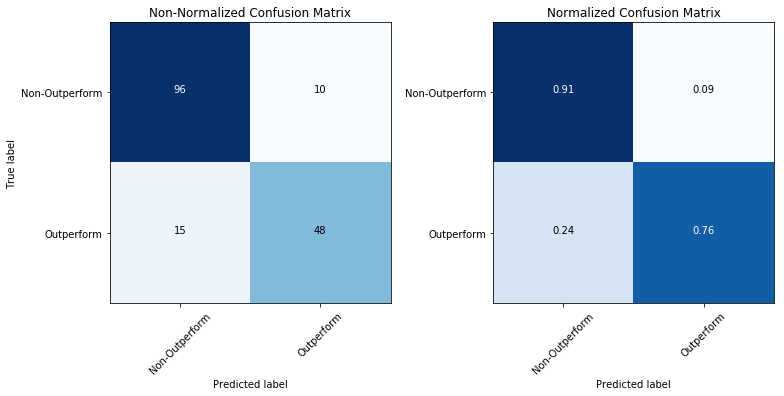

In [55]:
print("\n\n Parameters from best model:\n", grid_rf.best_params_)
print("\nPrecision: %0.2f" % precision_score(y_test, grid_rf.predict(X_test)))
print("Accuracy: %0.2f" % accuracy_score(y_test, grid_rf.predict(X_test)))
print("Recall: %0.2f" % recall_score(y_test, grid_rf.predict(X_test)))

crit = 'gini'
max_depth = 7
max_eatures = 'auto'
min_samples_leaf = 4
n_estimators = 100


cm = confusion_matrix(y_test, grid_rf.predict(X_test))
plt.figure(figsize = (11, 6))
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, ['Non-Outperform', 'Outperform'])
plt.title("Non-Normalized Confusion Matrix")
plt.subplot(1, 2, 2)
plot_confusion_matrix(cm, ['Non-Outperform', 'Outperform'], normalize=True)
plt.title("Normalized Confusion Matrix")
plt.ylabel("")
plt.show()

Our grid search took overnight to complete, but barely yielded better results than 